In [4]:
import sys
import os

# Add the parent directory of cell_segmentation to the Python path
cellvit_path = "/rsrch5/home/plm/yshokrollahi/CellViT"
if cellvit_path not in sys.path:
    sys.path.append(cellvit_path)
    print(f"Added {cellvit_path} to Python path")

# Now try to import the modules
try:
    from cell_segmentation.datasets.pannuke import PanNukeDataset
    from cell_segmentation.utils.tools import fix_duplicates, get_bounding_box
    print("Successfully imported PanNukeDataset and tools")
except ImportError as e:
    print(f"Import failed: {e}")

# Print the updated Python path
print("\nUpdated Python path:")
for path in sys.path:
    print(path)

# Check the contents of the cell_segmentation directory
cell_segmentation_dir = os.path.join(cellvit_path, "cell_segmentation")
print("\nContents of cell_segmentation directory:")
for root, dirs, files in os.walk(cell_segmentation_dir):
    level = root.replace(cell_segmentation_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for file in files:
        print(f"{sub_indent}{file}")

Added /rsrch5/home/plm/yshokrollahi/CellViT to Python path
Import failed: No module named 'natsort'

Updated Python path:
/rsrch5/home/plm/yshokrollahi/CellViT/notebook
/usr/lib/python311.zip
/usr/lib/python3.11
/usr/lib/python3.11/lib-dynload

/usr/local/lib/python3.11/dist-packages
/usr/lib/python3/dist-packages
/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p/
/rsrch5/home/plm/yshokrollahi/CellViT
/homes/fhoerst/histo-projects/CellViT/

Contents of cell_segmentation directory:
cell_segmentation/
    ._.DS_Store
    __init__.py
    run_stardist.py
    run_cellvit.py
    .DS_Store
    run_cpp_net.py
    inference/
        inference_cellvit_experiment_monuseg.py
        ._.DS_Store
        inference_cellvit_experiment_pannuke.py
        __init__.py
        cell_detection_mp.py
        .DS_Store
        inference_cpp_net_experiment_pannuke.py
        inference.ipynb
        cell_detection_256.py
        inference_stardist_experiment_pannuke.py
        cell_detection.py
        .ipynb_c

In [1]:
!pip install natsort

# Verify installation
import importlib
import natsort
print(f"natsort version: {natsort.__version__}")

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
natsort version: 8.4.0


In [17]:
# PanNuke Preprocessing Notebook

import sys
import os
from pathlib import Path
import subprocess

# Cell 1: Setup paths and environment

# Add the CellViT directory to the Python path
cellvit_path = "/rsrch5/home/plm/yshokrollahi/CellViT"
sys.path.append(cellvit_path)

# Define input and output paths
input_path = Path("/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p/data/Pannuke")
output_path = Path("/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p/data/processed/panNuke")

# Ensure output directory exists
output_path.mkdir(parents=True, exist_ok=True)

# Cell 2: Run prepare_pannuke.py script

In [19]:
from pathlib import Path

config_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble")

print("Contents of the config directory:")
for item in config_path.iterdir():
    print(f"- {item.name}")

# Check for specific files
print("\nChecking for specific files:")
print(f"dataset_config.yaml exists: {(config_path / 'dataset_config.yaml').exists()}")
print(f"weight_config.yaml exists: {(config_path / 'weight_config.yaml').exists()}")

# Check for fold-specific files
for fold in [0, 1, 2]:
    fold_path = config_path / f"fold{fold}"
    if fold_path.exists():
        print(f"\nContents of fold{fold}:")
        for item in fold_path.iterdir():
            print(f"- {item.name}")

Contents of the config directory:
- ._.DS_Store
- dataset_config.yaml
- fold0
- weight_config.yaml
- ._fold0
- fold1
- .DS_Store
- ._weight_config.yaml
- fold2
- ._dataset_config.yaml
- ._fold2
- ._fold1

Checking for specific files:
dataset_config.yaml exists: True
weight_config.yaml exists: True

Contents of fold0:
- cell_count.csv
- ._images
- ._.DS_Store
- ._labels
- labels
- types.csv
- ._cell_count.csv
- ._types.csv
- images
- .DS_Store

Contents of fold1:
- cell_count.csv
- ._images
- ._.DS_Store
- ._labels
- labels
- types.csv
- ._cell_count.csv
- ._types.csv
- images
- .DS_Store

Contents of fold2:
- cell_count.csv
- ._images
- ._.DS_Store
- ._labels
- labels
- types.csv
- ._cell_count.csv
- ._types.csv
- images
- .DS_Store


In [22]:
from pathlib import Path
from cell_segmentation.datasets.pannuke import PanNukeDataset
import torch

# Use the config directory as the dataset path
dataset_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble")

print(f"Using dataset path: {dataset_path}")
print(f"Dataset path exists: {dataset_path.exists()}")

if dataset_path.exists():
    try:
        # Initialize PanNukeDataset
        pannuke_dataset = PanNukeDataset(
            dataset_path=dataset_path,
            folds=[0, 1, 2],  # Use all folds
            transforms=None,  # Add transforms if needed
            stardist=False,
            regression=False,
            cache_dataset=False
        )
        print(f"\nSuccessfully created PanNukeDataset with {len(pannuke_dataset)} samples.")

        # Basic dataset exploration
        print("\nExploring dataset:")
        img, masks, tissue_type, img_name = pannuke_dataset[0]
        print(f"First image shape: {img.shape}")
        print(f"First image tissue type: {tissue_type}")
        print(f"First image name: {img_name}")
        print("Available masks:")
        for key, value in masks.items():
            print(f"  {key}: {value.shape}")

        # Load cell count data
        pannuke_dataset.load_cell_count()
        print("\nLoaded cell count data.")

        # Get sampling weights
        tissue_weights = pannuke_dataset.get_sampling_weights_tissue(gamma=1)
        cell_weights = pannuke_dataset.get_sampling_weights_cell(gamma=1)
        combined_weights = pannuke_dataset.get_sampling_weights_cell_tissue(gamma=1)

        print(f"\nTissue weights shape: {tissue_weights.shape}")
        print(f"Cell weights shape: {cell_weights.shape}")
        print(f"Combined weights shape: {combined_weights.shape}")

    except Exception as e:
        print(f"An error occurred while creating or using the dataset: {str(e)}")
else:
    print("Dataset path does not exist. Please provide the correct path to the PanNuke dataset.")

# Additional checks
print("\nAdditional checks:")
print(f"weight_config.yaml exists: {(dataset_path / 'weight_config.yaml').exists()}")
print(f"dataset_config.yaml exists: {(dataset_path / 'dataset_config.yaml').exists()}")

for fold in [0, 1, 2]:
    fold_path = dataset_path / f"fold{fold}"
    print(f"\nChecking fold {fold}:")
    print(f"  Fold directory exists: {fold_path.exists()}")
    if fold_path.exists():
        print(f"  images directory exists: {(fold_path / 'images').exists()}")
        print(f"  labels directory exists: {(fold_path / 'labels').exists()}")
        print(f"  types.csv exists: {(fold_path / 'types.csv').exists()}")
        print(f"  cell_count.csv exists: {(fold_path / 'cell_count.csv').exists()}")

Using dataset path: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble
Dataset path exists: True

Successfully created PanNukeDataset with 15802 samples.

Exploring dataset:
First image shape: torch.Size([3, 256, 256])
First image tissue type: Breast
First image name: 0_0.png
Available masks:
  instance_map: torch.Size([256, 256])
  nuclei_type_map: torch.Size([256, 256])
  nuclei_binary_map: torch.Size([256, 256])
  hv_map: torch.Size([2, 256, 256])

Loaded cell count data.
An error occurred while creating or using the dataset: '._0_0.png'

Additional checks:
weight_config.yaml exists: True
dataset_config.yaml exists: True

Checking fold 0:
  Fold directory exists: True
  images directory exists: True
  labels directory exists: True
  types.csv exists: True
  cell_count.csv exists: True

Checking fold 1:
  Fold directory exists: True
  images directory exists: True
  labels directory exists: True
  types.csv exists: True
  cell_count.csv exists: True

Checking fold 2:
 

In [23]:
import os
from pathlib import Path

def remove_hidden_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.startswith('._') or file == '.DS_Store':
                os.remove(os.path.join(root, file))
                print(f"Removed: {os.path.join(root, file)}")

dataset_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble")
remove_hidden_files(dataset_path)
print("Hidden files removal complete.")

Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/._.DS_Store
Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/._fold0
Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/.DS_Store
Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/._weight_config.yaml
Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/._dataset_config.yaml
Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/._fold2
Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/._fold1
Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/fold0/._images
Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/fold0/._.DS_Store
Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/fold0/._labels
Removed: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/fold0/._cell_count.csv
Removed: /rsrch

In [24]:
from pathlib import Path
from cell_segmentation.datasets.pannuke import PanNukeDataset
import torch
import traceback

dataset_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble")

print(f"Using dataset path: {dataset_path}")
print(f"Dataset path exists: {dataset_path.exists()}")

if dataset_path.exists():
    try:
        pannuke_dataset = PanNukeDataset(
            dataset_path=dataset_path,
            folds=[0, 1, 2],
            transforms=None,
            stardist=False,
            regression=False,
            cache_dataset=False
        )
        print(f"\nSuccessfully created PanNukeDataset with {len(pannuke_dataset)} samples.")

        print("\nExploring dataset:")
        img, masks, tissue_type, img_name = pannuke_dataset[0]
        print(f"First image shape: {img.shape}")
        print(f"First image tissue type: {tissue_type}")
        print(f"First image name: {img_name}")
        print("Available masks:")
        for key, value in masks.items():
            print(f"  {key}: {value.shape}")

        try:
            pannuke_dataset.load_cell_count()
            print("\nSuccessfully loaded cell count data.")
        except Exception as e:
            print(f"\nError loading cell count data: {str(e)}")
            print(traceback.format_exc())

        try:
            tissue_weights = pannuke_dataset.get_sampling_weights_tissue(gamma=1)
            cell_weights = pannuke_dataset.get_sampling_weights_cell(gamma=1)
            combined_weights = pannuke_dataset.get_sampling_weights_cell_tissue(gamma=1)
            print(f"\nTissue weights shape: {tissue_weights.shape}")
            print(f"Cell weights shape: {cell_weights.shape}")
            print(f"Combined weights shape: {combined_weights.shape}")
        except Exception as e:
            print(f"\nError calculating weights: {str(e)}")
            print(traceback.format_exc())

    except Exception as e:
        print(f"An error occurred while creating or using the dataset: {str(e)}")
        print(traceback.format_exc())
else:
    print("Dataset path does not exist. Please provide the correct path to the PanNuke dataset.")

print("\nAdditional checks:")
print(f"weight_config.yaml exists: {(dataset_path / 'weight_config.yaml').exists()}")
print(f"dataset_config.yaml exists: {(dataset_path / 'dataset_config.yaml').exists()}")

for fold in [0, 1, 2]:
    fold_path = dataset_path / f"fold{fold}"
    print(f"\nChecking fold {fold}:")
    print(f"  Fold directory exists: {fold_path.exists()}")
    if fold_path.exists():
        print(f"  images directory exists: {(fold_path / 'images').exists()}")
        print(f"  labels directory exists: {(fold_path / 'labels').exists()}")
        print(f"  types.csv exists: {(fold_path / 'types.csv').exists()}")
        print(f"  cell_count.csv exists: {(fold_path / 'cell_count.csv').exists()}")

Using dataset path: /rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble
Dataset path exists: True

Successfully created PanNukeDataset with 7901 samples.

Exploring dataset:
First image shape: torch.Size([3, 256, 256])
First image tissue type: Breast
First image name: 0_0.png
Available masks:
  instance_map: torch.Size([256, 256])
  nuclei_type_map: torch.Size([256, 256])
  nuclei_binary_map: torch.Size([256, 256])
  hv_map: torch.Size([2, 256, 256])

Successfully loaded cell count data.

Tissue weights shape: torch.Size([7901])
Cell weights shape: torch.Size([7901])
Combined weights shape: torch.Size([7901])

Additional checks:
weight_config.yaml exists: True
dataset_config.yaml exists: True

Checking fold 0:
  Fold directory exists: True
  images directory exists: True
  labels directory exists: True
  types.csv exists: True
  cell_count.csv exists: True

Checking fold 1:
  Fold directory exists: True
  images directory exists: True
  labels directory exists: True
  typ

Dataset size: 7901


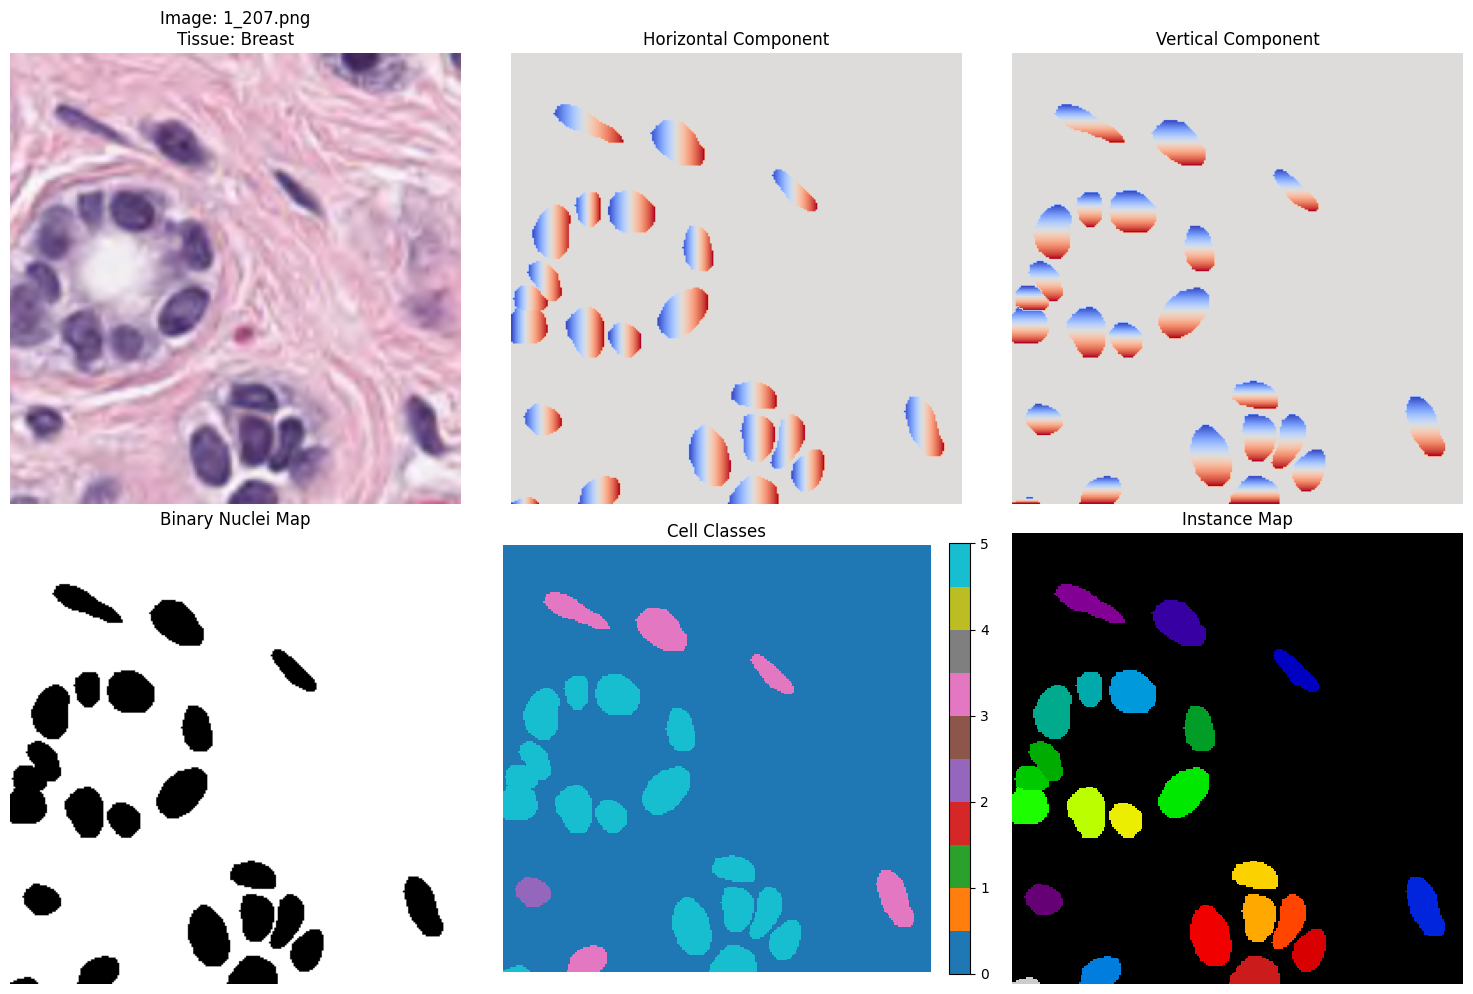

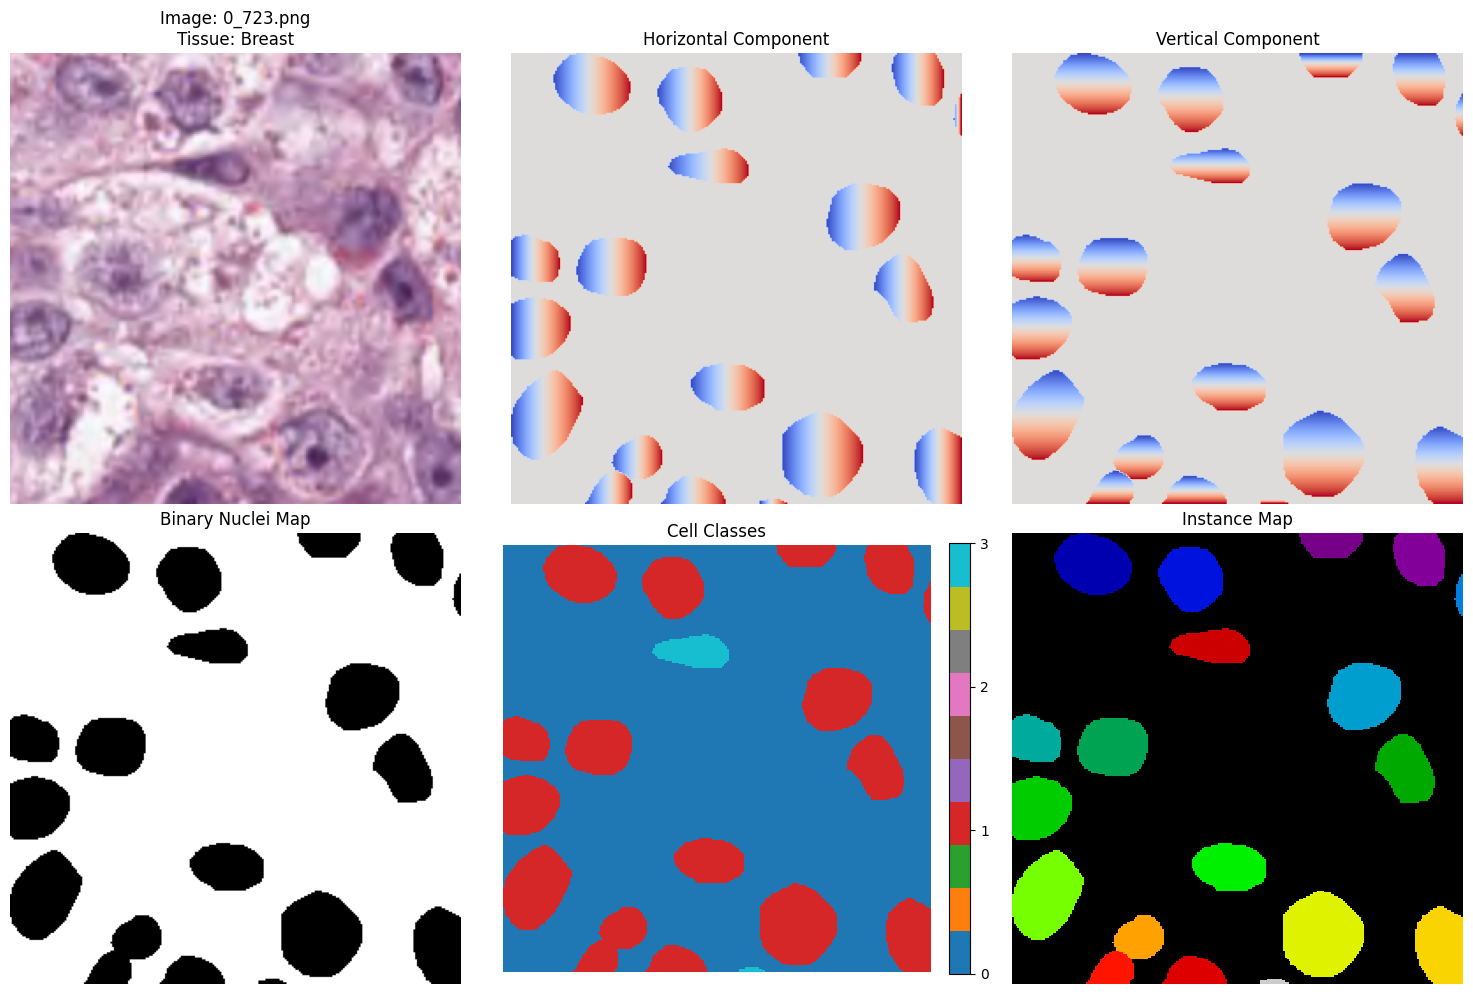

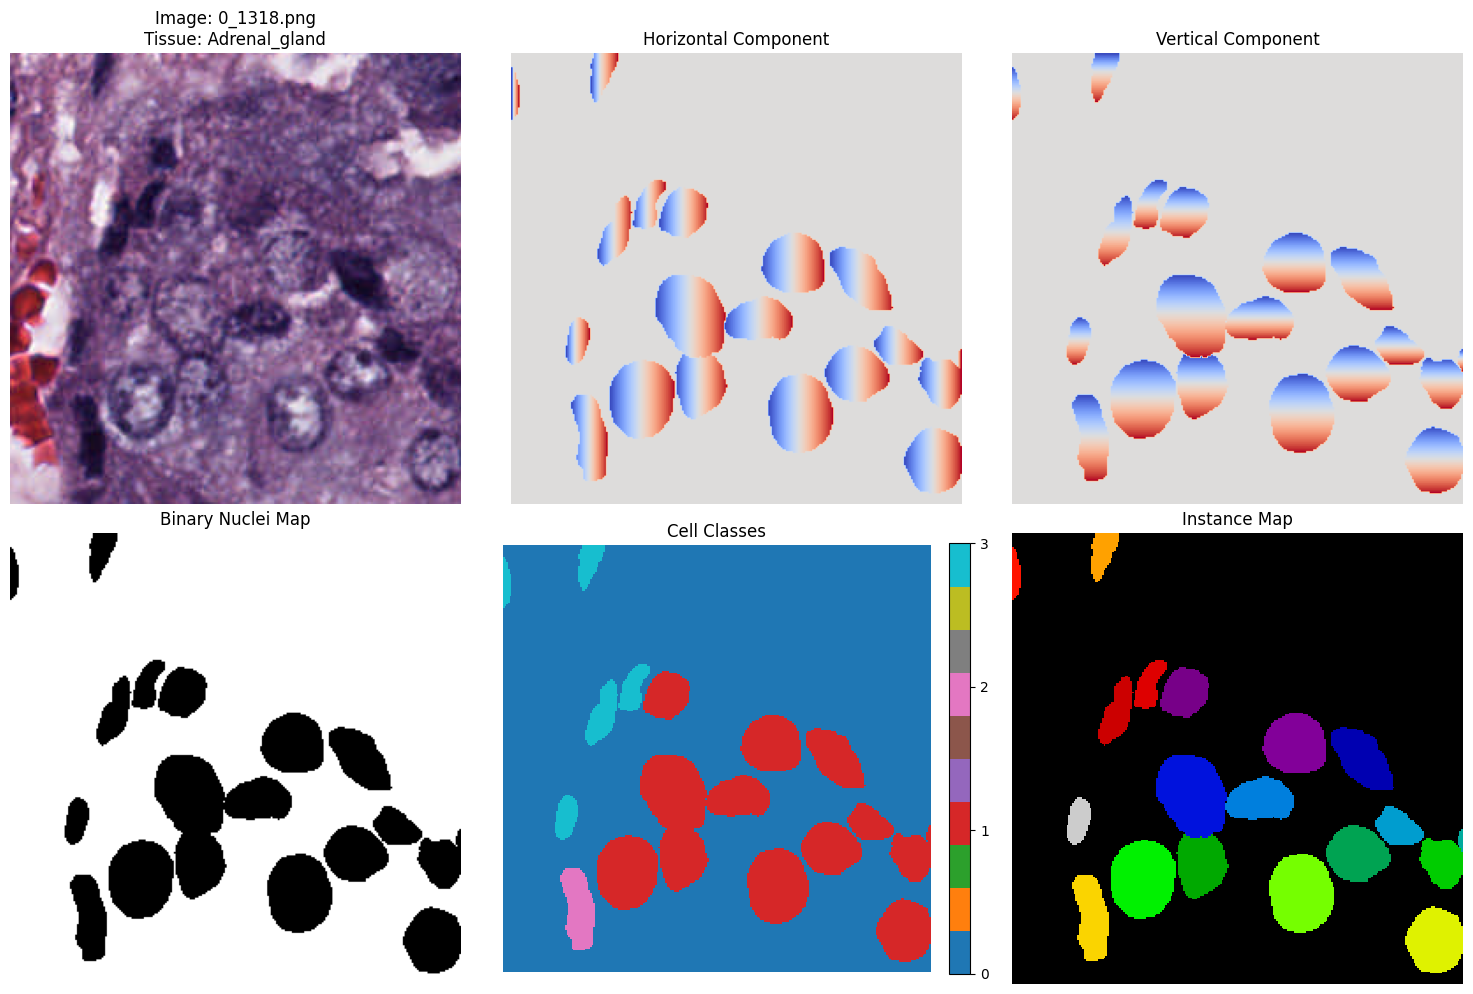

In [73]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from cell_segmentation.datasets.pannuke import PanNukeDataset

# Add the CellViT project path to sys.path if necessary
cellvit_path = "/rsrch5/home/plm/yshokrollahi/CellViT"
if cellvit_path not in sys.path:
    sys.path.append(cellvit_path)

# Set up the dataset
dataset_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble")
folds = [0, 1, 2]
transforms = None
stardist = False
regression = False
cache_dataset = False

# Create the PanNukeDataset instance
pannuke_dataset = PanNukeDataset(
    dataset_path=dataset_path,
    folds=folds,
    transforms=transforms,
    stardist=stardist,
    regression=regression,
    cache_dataset=cache_dataset
)

print(f"Dataset size: {len(pannuke_dataset)}")

# Define a color map for cell classes
cell_class_cmap = plt.cm.get_cmap('tab10')  # You can change this to any colormap you prefer

# Function to visualize image, HV map, binary map, and cell classes
def visualize_pannuke_data(img, masks, tissue_type, img_name):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Display the original image
    axs[0, 0].imshow(img.permute(1, 2, 0))
    axs[0, 0].set_title(f"Image: {img_name}\nTissue: {tissue_type}")
    axs[0, 0].axis('off')
    
    # Display the horizontal component of the HV map
    axs[0, 1].imshow(masks['hv_map'][0], cmap='coolwarm', vmin=-1, vmax=1)
    axs[0, 1].set_title("Horizontal Component")
    axs[0, 1].axis('off')
    
    # Display the vertical component of the HV map
    axs[0, 2].imshow(masks['hv_map'][1], cmap='coolwarm', vmin=-1, vmax=1)
    axs[0, 2].set_title("Vertical Component")
    axs[0, 2].axis('off')
    
    # Display the binary nuclei map
    axs[1, 0].imshow(masks['nuclei_binary_map'], cmap='binary')
    axs[1, 0].set_title("Binary Nuclei Map")
    axs[1, 0].axis('off')
    
    # Display the nuclei type map (cell classes)
    cell_classes = masks['nuclei_type_map'].numpy()
    im = axs[1, 1].imshow(cell_classes, cmap=cell_class_cmap, interpolation='nearest')
    axs[1, 1].set_title("Cell Classes")
    axs[1, 1].axis('off')
    
    # Add a colorbar for the cell classes
    cbar = plt.colorbar(im, ax=axs[1, 1], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_ticks(np.arange(cell_classes.max() + 1))
    cbar.set_ticklabels(range(cell_classes.max() + 1))
    
    # Display the instance map
    instance_map = masks['instance_map'].numpy()
    axs[1, 2].imshow(instance_map, cmap='nipy_spectral', interpolation='nearest')
    axs[1, 2].set_title("Instance Map")
    axs[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize data for a few samples
num_samples = 3
for i in range(num_samples):
    # Get a random sample
    index = np.random.randint(0, len(pannuke_dataset))
    img, masks, tissue_type, img_name = pannuke_dataset[index]
    
    # Visualize the data
    visualize_pannuke_data(img, masks, tissue_type, img_name)

## Sam-H CELLVIT

In [1]:
import os
import sys
import yaml
from pathlib import Path

# Add the CellViT project path to sys.path if necessary
cellvit_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT")
if str(cellvit_path) not in sys.path:
    sys.path.append(str(cellvit_path))

# Load the configuration file
config_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/examples/cell_segmentation/pannuke-cellvit-sam-h.yaml")
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

    
config['run_sweep'] = False
# Import necessary modules
from cell_segmentation.experiments.experiment_cellvit_pannuke import ExperimentCellVitPanNuke
from cell_segmentation.inference.inference_cellvit_experiment_pannuke import InferenceCellViT

# Create the experiment
experiment = ExperimentCellVitPanNuke(default_conf=config)

print("Experiment object created successfully")

# Run the experiment
print("Starting the experiment...")
outdir = experiment.run_experiment()
print(f"Experiment completed. Output directory: {outdir}")

# Set up and run inference
inference = InferenceCellViT(
    run_dir=outdir,
    gpu=config['gpu'],
    checkpoint_name=config['eval_checkpoint'],
    magnification=config['data'].get('magnification', 40),
)

print("Setting up inference...")
trained_model, inference_dataloader, dataset_config = inference.setup_patch_inference()

print("Running inference...")
inference.run_patch_inference(
    trained_model,
    inference_dataloader,
    dataset_config,
    generate_plots=True,  # Set to True to generate plots
)

print("Inference completed.")

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-11 21:12:42.760501: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 21:12:42.790992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 21:12:42.791015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 21:12:42.792023: E external/l

Experiment object created successfully
Starting the experiment...


2024-10-11 21:12:44,585 [INFO] - Instantiated Logger. WandB init and config update finished.
2024-10-11 21:12:44,586 [INFO] - Run ist stored here: /rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-10-11T211243_cellvit-sam-h-no-tc
2024-10-11 21:12:44,688 [INFO] - Cuda devices: [<torch.cuda.device object at 0x7f5fa41a99d0>, <torch.cuda.device object at 0x7f60b1c33450>]
2024-10-11 21:12:44,691 [INFO] - Using GPU: cuda:0
2024-10-11 21:12:44,692 [INFO] - Using device: cuda:0
2024-10-11 21:12:44,694 [INFO] - Loss functions:
2024-10-11 21:12:44,696 [INFO] - {'nuclei_binary_map': {'dice': {'loss_fn': DiceLoss(), 'weight': 1.0}, 'focaltverskyloss': {'loss_fn': FocalTverskyLoss(), 'weight': 1.0}}, 'hv_map': {'mse': {'loss_fn': MSELossMaps(), 'weight': 2.5}, 'msge': {'loss_fn': MSGELossMaps(), 'weight': 8.0}}, 'nuclei_type_map': {'bce': {'loss_fn': XentropyLoss(), 'weight': 0.5}, 'dice': {'loss_fn': DiceLoss(), 'weight': 0.2}, 'mcfocaltverskyloss': {'loss_fn': MCFocalTverskyLos

/rsrch5/home/plm/yshokrollahi/CellViT/cell_segmentation/experiments/experiment_cellvit_pannuke.py:766: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(p=p, sigma=25, alpha=0.5, alpha_affine=15)


2024-10-11 21:13:02,639 [INFO] - Using Weighted Sampling with strategy: cell
2024-10-11 21:13:02,641 [INFO] - Unique-Weights: tensor([ 1.9520,  2.4499,  2.4693,  3.8447,  4.2518,  4.2712,  4.7691,  5.3919,
         5.6467,  6.1446,  6.1640,  6.5711,  7.1939,  7.6917,  7.9465,  7.9659,
         9.4937,  9.5131, 10.0110, 10.2658, 11.8130, 13.2078])
2024-10-11 21:13:02,643 [INFO] - Instantiate Trainer
2024-10-11 21:13:02,646 [INFO] - Calling Trainer Fit
2024-10-11 21:13:02,651 [INFO] - Starting training, total number of epochs: 130
2024-10-11 21:13:02,653 [INFO] - Epoch: 1/130


100%|██████████| 166/166 [01:12<00:00,  2.31it/s, Loss=7.88, Dice=0.74, Pred-Acc=0.025] 

2024-10-11 21:14:15,232 [INFO] - Training epoch stats:     Loss: 7.8795 - Binary-Cell-Dice: 0.7404 - Binary-Cell-Jacard: 0.6123 - Tissue-MC-Acc.: 0.0248


2024-10-11 21:14:21,863 [INFO] - Epoch: 2/130


100%|██████████| 166/166 [01:15<00:00,  2.20it/s, Loss=5.88, Dice=0.791, Pred-Acc=0.024]

2024-10-11 21:15:38,014 [INFO] - Training epoch stats:     Loss: 5.8814 - Binary-Cell-Dice: 0.7915 - Binary-Cell-Jacard: 0.6728 - Tissue-MC-Acc.: 0.0245


2024-10-11 21:15:43,837 [INFO] - Epoch: 3/130


100%|██████████| 166/166 [02:20<00:00,  1.18it/s, Loss=5.59, Dice=0.797, Pred-Acc=0.027]

2024-10-11 21:18:05,147 [INFO] - Training epoch stats:     Loss: 5.5901 - Binary-Cell-Dice: 0.7969 - Binary-Cell-Jacard: 0.6795 - Tissue-MC-Acc.: 0.0267


2024-10-11 21:18:11,290 [INFO] - Epoch: 4/130


100%|██████████| 166/166 [02:48<00:00,  1.02s/it, Loss=5.5, Dice=0.8, Pred-Acc=0.029]   

2024-10-11 21:21:00,921 [INFO] - Training epoch stats:     Loss: 5.4951 - Binary-Cell-Dice: 0.8004 - Binary-Cell-Jacard: 0.6857 - Tissue-MC-Acc.: 0.0286


2024-10-11 21:21:07,048 [INFO] - Epoch: 5/130


100%|██████████| 166/166 [01:14<00:00,  2.24it/s, Loss=5.43, Dice=0.808, Pred-Acc=0.029]

2024-10-11 21:22:21,847 [INFO] - Training epoch stats:     Loss: 5.4284 - Binary-Cell-Dice: 0.8078 - Binary-Cell-Jacard: 0.6935 - Tissue-MC-Acc.: 0.0286


2024-10-11 21:22:27,551 [INFO] - Epoch: 6/130


 47%|████▋     | 78/166 [00:36<00:41,  2.11it/s, Loss=5.34, Dice=0.817, Pred-Acc=0.028]


KeyboardInterrupt: 

In [1]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


## VITAMINP

In [2]:
import os
import sys
import yaml
from pathlib import Path

# Add the CellViT project path to sys.path if necessary
cellvit_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT")
if str(cellvit_path) not in sys.path:
    sys.path.append(str(cellvit_path))

# Load the configuration file for VitaminP
config_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/examples/cell_segmentation/pannuke-vitaminp.yaml")
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

config['run_sweep'] = False

# Import necessary modules
from cell_segmentation.experiments.experiment_cellvit_pannuke import ExperimentCellVitPanNuke
from cell_segmentation.inference.inference_cellvit_experiment_pannuke import InferenceCellViT

# Create the experiment
experiment = ExperimentCellVitPanNuke(default_conf=config)
print("Experiment object created successfully")

# Run the experiment
print("Starting the experiment...")
outdir = experiment.run_experiment()
print(f"Experiment completed. Output directory: {outdir}")

# Set up and run inference
inference = InferenceCellViT(
    run_dir=outdir,
    gpu=config['gpu'],
    checkpoint_name=config['eval_checkpoint'],
    magnification=config['data'].get('magnification', 40),
)

print("Setting up inference...")
trained_model, inference_dataloader, dataset_config = inference.setup_patch_inference()

print("Running inference...")
inference.run_patch_inference(
    trained_model,
    inference_dataloader,
    dataset_config,
    generate_plots=True,  # Set to True to generate plots
)

print("Inference completed.")

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-11 21:05:48.575839: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 21:05:48.605969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 21:05:48.605993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 21:05:48.606947: E external/l

Experiment object created successfully
Starting the experiment...


2024-10-11 21:05:50,332 [INFO] - Instantiated Logger. WandB init and config update finished.
2024-10-11 21:05:50,332 [INFO] - Run ist stored here: /rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-10-11T210549_cellvit-vitaminp
2024-10-11 21:05:50,375 [INFO] - Cuda devices: [<torch.cuda.device object at 0x7f54b6681250>, <torch.cuda.device object at 0x7f54b6686d10>]
2024-10-11 21:05:50,377 [INFO] - Using GPU: cuda:0
2024-10-11 21:05:50,380 [INFO] - Using device: cuda:0
2024-10-11 21:05:50,383 [INFO] - Loss functions:
2024-10-11 21:05:50,384 [INFO] - {'nuclei_binary_map': {'dice': {'loss_fn': DiceLoss(), 'weight': 1.0}, 'focaltverskyloss': {'loss_fn': FocalTverskyLoss(), 'weight': 1.0}}, 'hv_map': {'mse': {'loss_fn': MSELossMaps(), 'weight': 2.5}, 'msge': {'loss_fn': MSGELossMaps(), 'weight': 8.0}}, 'nuclei_type_map': {'bce': {'loss_fn': XentropyLoss(), 'weight': 0.5}, 'dice': {'loss_fn': DiceLoss(), 'weight': 0.2}, 'mcfocaltverskyloss': {'loss_fn': MCFocalTverskyLoss()

/rsrch5/home/plm/yshokrollahi/CellViT/cell_segmentation/experiments/experiment_cellvit_pannuke.py:782: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(p=p, sigma=25, alpha=0.5, alpha_affine=15)


2024-10-11 21:06:01,856 [INFO] - Using Weighted Sampling with strategy: cell
2024-10-11 21:06:01,858 [INFO] - Unique-Weights: tensor([ 1.9520,  2.4499,  2.4693,  3.8447,  4.2518,  4.2712,  4.7691,  5.3919,
         5.6467,  6.1446,  6.1640,  6.5711,  7.1939,  7.6917,  7.9465,  7.9659,
         9.4937,  9.5131, 10.0110, 10.2658, 11.8130, 13.2078])
2024-10-11 21:06:01,861 [INFO] - Instantiate Trainer
2024-10-11 21:06:01,864 [INFO] - Calling Trainer Fit
2024-10-11 21:06:01,867 [INFO] - Starting training, total number of epochs: 130
2024-10-11 21:06:01,869 [INFO] - Epoch: 1/130


  0%|          | 0/166 [00:00<?, ?it/s]

VitaminP forward pass - nuclei_type_map shape: torch.Size([16, 6, 256, 256])
Branch: nuclei_binary_map, Loss: dice
Prediction shape: torch.Size([16, 2, 256, 256])
Ground truth shape: torch.Size([16, 2, 256, 256])
Loss value: 1.0325548648834229
new files
Branch: nuclei_binary_map, Loss: focaltverskyloss
Prediction shape: torch.Size([16, 2, 256, 256])
Ground truth shape: torch.Size([16, 2, 256, 256])
Loss value: 0.3514801859855652
new files
Branch: hv_map, Loss: mse
Prediction shape: torch.Size([16, 2, 256, 256])
Ground truth shape: torch.Size([16, 2, 256, 256])
Loss value: 0.16002491116523743
new files
Branch: hv_map, Loss: msge
Prediction shape: torch.Size([16, 2, 256, 256])
Ground truth shape: torch.Size([16, 2, 256, 256])
Loss value: 1.1713396310806274
new files
Branch: tissue_types, Loss: ce
Prediction shape: torch.Size([16, 19])
Ground truth shape: torch.Size([16])
Loss value: 3.0726318359375
new files
Branch: nuclei_type_map, Loss: bce
Prediction shape: torch.Size([16, 6, 256, 256

  0%|          | 0/166 [00:01<?, ?it/s]


RuntimeError: The size of tensor a (2) must match the size of tensor b (6) at non-singleton dimension 0